# Импорт библиотек

In [1]:
import math
import scipy
import warnings
import math as m
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification, make_regression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import rmse, aic

# Настройка окружения

In [2]:
plt.rcParams['figure.figsize'] = 11, 7
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

# Алгоритмы

## Helper-functions

In [3]:
def compute_loss(params, X, y, idxs, mu=0.5):
    # Unpack params
    w = params[:X.shape[0]]
    w0 = params[X.shape[0]]
    
    lambdas = params[X.shape[0]+1:]
    lambdas = lambdas[idxs]
    
    # Calculate hinge loss
    distances = 1 - y * (X @ w + w0)
    # distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = (np.dot(lambdas.T, distances))
    
    # calculate cost
    cost = mu * (w.T @ w) + mu * w0*w0 + hinge_loss
    
    return cost


def full_loss(params, X, y, mu=0.5):
    # Unpack params
    w = params[:X.shape[1]]
    w0 = params[X.shape[1]]
    
    lambdas = params[X.shape[1]+1:]
    
    # Calculate hinge loss
    distances = 1 - y * (X @ w + w0)
    # distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss  = np.sum(distances)

    
    # calculate cost
    cost = mu * (w.T @ w) + mu * w0*w0 + hinge_loss
    
    return cost



def loss_grad(loss, params, X_batch, y_batch, e_sample, idxs, tau, dim_x, dim_y):
    # Unpack params
    weights = params[:dim_x]
    lambdas = params[dim_x:]
    
    e_xk = e_sample[:, :dim_x]
    e_yk = e_sample[:, dim_x:]
    
    bs = len(X_batch)
    
    grad_w = np.zeros(len(weights))
    grad_l = np.zeros(len(lambdas))
    
    
    for i in np.arange(bs):
        grad_w += (loss(np.concatenate((weights + tau*e_xk[i], lambdas)), X_batch[i], y_batch[i], idxs[i]) - loss(np.concatenate((weights - tau*e_xk[i], lambdas)), X_batch[i], y_batch[i], idxs[i]) ) / (bs) * (dim_x) / (2*tau) * e_xk[i]
        grad_l += (loss(np.concatenate((weights, lambdas+tau*e_yk[i])), X_batch[i], y_batch[i], idxs[i]) - loss(np.concatenate((weights, lambdas-tau*e_yk[i])), X_batch[i], y_batch[i], idxs[i]) ) / (bs) * (dim_y) / (2*tau) * (e_yk[i]) 
    
    return np.concatenate((grad_w, -grad_l))


def prox_SVM(z, xi):
    return z - xi


def sample_data(X, y, batch_size):
    idxs = np.random.choice(len(X), size=batch_size, replace=False)
    X_batch = X[idxs]
    y_batch = y[idxs]
    
    return X_batch, y_batch, idxs


def sample_spherical(ndim, batch_size):
    sample = []
    
    for i in np.arange(batch_size):
        vec = np.random.randn(ndim)
        vec /= np.linalg.norm(vec, axis=0)
        sample.append(vec)
        
    return sample
    

## 0-order Mirror Prox

In [4]:
def optimize_MP(z_init, X, y, loss, sample_data, sample_e, prox, N_iter, dim_x, dim_y, tau, batch_size=10):
    
    loss_list = []
    #loss_list.append(loss(z_init, X, y))
    
    z_res = 0
    param_list =[]
    step_list = []
    
    
    z_prev = z_init
    
    for i in tqdm(np.arange(N_iter)):
        
        # Sample required variables
        e_xk = sample_e(dim_x, batch_size)
        e_yk = sample_e(dim_y, batch_size)
        e_k = np.hstack((e_xk, e_yk))
        X_batch, y_batch, idxs = sample_data(X, y, batch_size)
        
        # Calculate gamma
        gamma_k = m.sqrt(2/(i+1))
        step_list.append(gamma_k)
        #gamma_k = 1e-1
        
        F_z = loss_grad(loss, z_prev, X_batch, y_batch, e_k, idxs, tau, dim_x, dim_y)
        w_new = prox(z_prev, gamma_k * F_z)
        
        F_w = loss_grad(loss, w_new, X_batch, y_batch, e_k, idxs, tau, dim_x, dim_y)
        z_new = prox(z_prev, gamma_k * F_w)
        
        loss_list.append(full_loss(z_new, X, y))
        param_list.append(w_new[:dim_x])
        
        z_res += gamma_k*w_new
        z_prev = z_new
        
    return z_res/np.sum(step_list), param_list, loss_list
    

## 0-order Mirror Descent

In [5]:
def optimize_MD(z_init, X, y, loss, sample_data, sample_e, prox, N_iter, dim_x, dim_y, tau, batch_size=1):
    
    loss_list = []
    #loss_list.append(loss(z_init, X, y))
    
    param_list =[]
    step_list = []
    param_list.append(z_init[:dim_x])
    
    z_res = 0
    z_prev = z_init
    
    #X_batch, y_batch, idxs = X, y, np.arange(len(X))
    full_idx = np.arange(len(X))
     
    
    for i in tqdm(np.arange(N_iter)):
        # Sample required variables
        e_xk = sample_e(dim_x, batch_size)
        e_yk = sample_e(dim_y, batch_size)
        e_k = np.hstack((e_xk, e_yk))
        X_batch, y_batch, idxs = sample_data(X, y, batch_size)
        
        # Approximate grad
        g_k = loss_grad(loss, z_prev, X_batch, y_batch, e_k, idxs, tau, dim_x, dim_y)
         
        
        # Calculate gamma
        gamma_k = m.sqrt(2/(i+1))
        step_list.append(gamma_k)
        #gamma_k = 1e-1
        
        # Update params
        z_new = prox(z_prev, gamma_k * g_k)
        
        loss_list.append(full_loss(z_new, X, y))
        param_list.append(z_new[:dim_x])
        
        z_res += gamma_k*z_prev
        z_prev = z_new
    
    
    return z_res/np.sum(step_list), param_list, loss_list

# Численные эксперименты

## Синтетические данные малой размерности

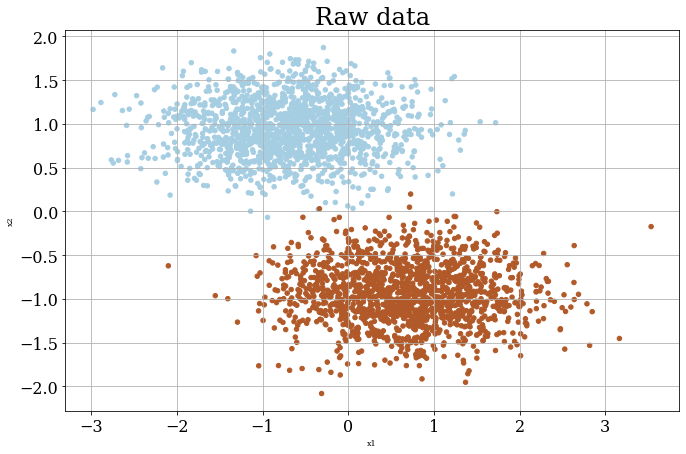

In [35]:
X_train, y_train = make_blobs(n_samples=3000, centers=2, random_state=0, cluster_std=0.60)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, s=20)
plt.title("Raw data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid()
plt.show()

for i in np.arange(len(y_train)):
    if y_train[i] == 0:
        y_train[i] = -1

In [36]:
# Random SVM weights
# weights = np.random.rand(X_train.shape[1]+1)
weights_init = np.zeros(X_train.shape[1]+1)

# Dual vars
# lambdas = np.random.rand(len(X_train))
lambdas_init = np.zeros(len(X_train))

# Stack them
params_init = np.concatenate((weights_init, lambdas_init))


# Launch train 
params, param_log, loss_log = optimize_MD(params_init, X_train, y_train, loss=compute_loss, 
                     sample_data=sample_data, sample_e=sample_spherical, prox=prox_SVM,
                     dim_x=len(weights_init), dim_y=len(lambdas_init), 
                     N_iter=1100, tau=1e-6, batch_size=100)

params_p, param_log_p, loss_log_p = optimize_MP(params_init, X_train, y_train, loss=compute_loss, 
                     sample_data=sample_data, sample_e=sample_spherical, prox=prox_SVM,
                     dim_x=len(weights_init), dim_y=len(lambdas_init), 
                     N_iter=1100, tau=1e-7, batch_size=100)

100%|██████████| 1100/1100 [00:42<00:00, 26.19it/s]


In [37]:
def predict(x, w, w0):
    return w @ x + w0

def plotHyperPlane(ax, params, X, y):
    # plot the line, the points, and the nearest vectors to the plane
    x1min, x2min = np.min(X, axis=0)
    x1max, x2max = np.max(X, axis=0)
    
    xx = np.linspace(x1min, x1max, 10)
    yy = np.linspace(x2min, x2max, 10)

    X1, X2 = np.meshgrid(xx, yy)
    Z = np.empty(X1.shape)
    
    for (i, j), val in np.ndenumerate(X1):
        x1 = val
        x2 = X2[i, j]
        p = predict([x1, x2], w=params[:X.shape[1]], w0=params[X.shape[1]])
        Z[i, j] = p
        
    levels = [-1.0, 0.0, 1.0]
    linestyles = ['dashed', 'solid', 'dashed']
    colors = 'k'
    
    ax.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
    
    #ax.set_title(("(%.3f)x1+(%.3f)x2+(%.3f)=0")%(H_params[0][0],H_params[0][1],H_params[1]))
    
    
    ax.text(0, 1.01, ("HyperPlane: (%.3f)x1+(%.3f)x2+(%.3f)=0")%(params[:X.shape[1]][0], params[:X.shape[1]][1], params[X.shape[1]]), 
            fontsize=12, transform=ax.transAxes)
    ax.grid()
    

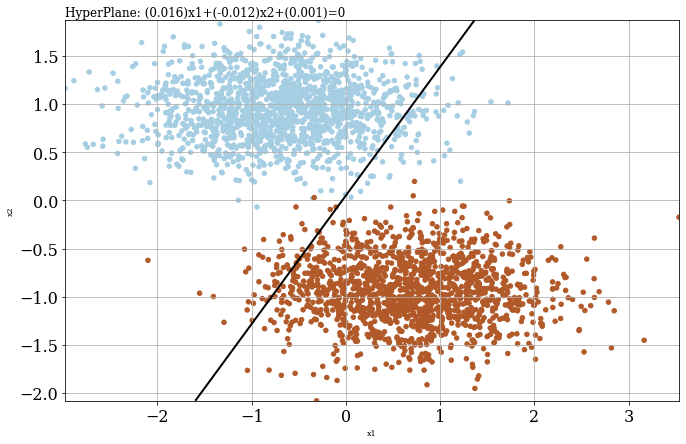

In [38]:
fig, ax = plt.subplots()
ax.set_xlabel("x1");  ax.set_ylabel("x2")

plotHyperPlane(ax, params[:X_train.shape[1]+1], X=X_train, y=y_train)

[ 0.01562646 -0.01170275  0.00059951 ...  0.20371315 -0.19081335
 -0.26367371]


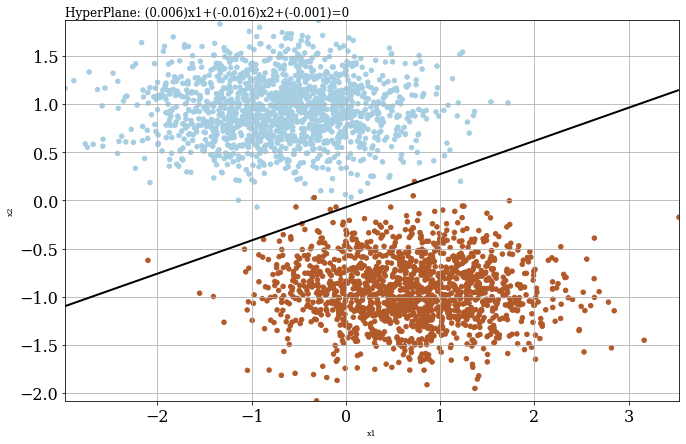

In [39]:
fig, ax = plt.subplots()
ax.set_xlabel("x1");  ax.set_ylabel("x2")

plotHyperPlane(ax, params_p[:X_train.shape[1]+1], X=X_train, y=y_train)
print(params)

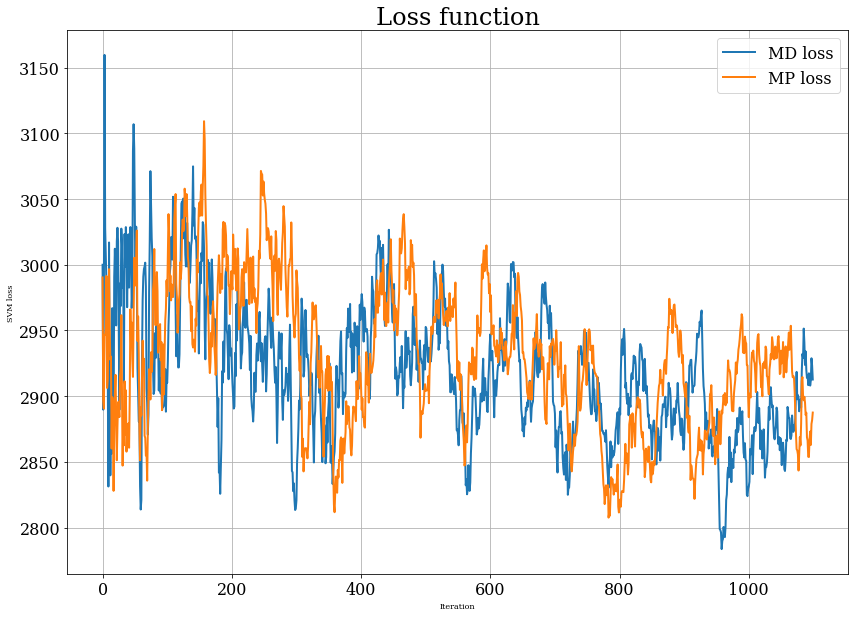

In [41]:
plt.figure(figsize=(14, 10))
plt.plot(loss_log, label=r"MD loss", linewidth=2)
plt.plot(loss_log_p, label=r"MP loss", linewidth=2)
plt.title("Loss function")
plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("SVM loss")
plt.grid()


## Задача классификации большой размерности

In [19]:
X, Y = make_classification(n_samples=3000, n_features=10, 
                           n_informative=8, n_classes=2, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=40)

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=500, random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

for i in np.arange(len(y_train)):
    if y_train[i] == 0:
        y_train[i] = -1
        
for i in np.arange(len(y_test)):
    if y_test[i] == 0:
        y_test[i] = -1

In [42]:
# Random SVM weights
# weights = np.random.rand(X_train.shape[1]+1)
weights_init = np.zeros(X_train.shape[1]+1)

# Dual vars
# lambdas = np.random.rand(len(X_train))
lambdas_init = np.zeros(len(X_train))

# Stack them
params_init = np.concatenate((weights_init, lambdas_init))


# Launch train 
params, param_log, loss_log = optimize_MD(params_init, X_train, y_train, loss=compute_loss, 
                     sample_data=sample_data, sample_e=sample_spherical, prox=prox_SVM,
                     dim_x=len(weights_init), dim_y=len(lambdas_init), 
                     N_iter=1100, tau=1e-6, batch_size=100)

params_p, param_log_p, loss_log_p = optimize_MP(params_init, X_train, y_train, loss=compute_loss, 
                     sample_data=sample_data, sample_e=sample_spherical, prox=prox_SVM,
                     dim_x=len(weights_init), dim_y=len(lambdas_init), 
                     N_iter=1100, tau=1e-7, batch_size=100)

100%|██████████| 1100/1100 [00:33<00:00, 32.53it/s]


In [21]:
counter = 0
for i in np.arange(len(X_test)):
    marg = y_test[i]*predict(X_test[i], w=params[:X_test.shape[1]], w0=params[X_test.shape[1]])
    if marg > 0:
        counter += 1
        
print(counter/len(y_test))

0.832


In [43]:
counter = 0
for i in np.arange(len(X_test)):
    marg = y_test[i]*predict(X_test[i], w=params_p[:X_test.shape[1]], w0=params_p[X_test.shape[1]])
    if marg > 0:
        counter += 1
        
print(counter/len(y_test))

0.576
